In [1]:
%pylab inline
from numpy import *
import pandas as pd
from scipy.optimize import root,minimize
import itertools
import math
import gurobipy as GRB
plt.style.use('seaborn-notebook')


Populating the interactive namespace from numpy and matplotlib


In [2]:
##Initialize users' information of locations
#--Input:Total number of locations, Total number of users, Release Time, Transition Matrix
#--Output: Released Real Counts
def initializeFunc(n_loc,n_user,time,TM):
    LocList = [lab for lab in range(n_loc)] #labels of locations
    p = copy(TM)
    FinalLocCount = [] #Array for recording final locations' counts 
    #random.seed(seed=202300001)
    
    for i in range(time):
        nextLoc = []
        LocCount = []
        if i==0:
            ##Generate initial locations in uniform distribution
            nextLoc = random.randint(0,n_loc,size = n_user)
        else:
            ##Calculate distribution of users in each location and generate locations in the next time by a given transition matrix
            inextLoc = []
            for j in range(n_loc):
                ichoosen = np.random.choice(LocList, size = FinalLocCount[i-1][j], p = array(p[j]).ravel())
                inextLoc= append(inextLoc,ichoosen)
            nextLoc.append(inextLoc)
        
        
        ##Counting for locations at each time point
        for i in range(0,n_loc):
            LocCount.append(sum(array(nextLoc) == i))
        
        ##Recording final counts
        FinalLocCount.append(LocCount)
        
    #print('The initialized result is: \n',array(FinalLocCount).T)
    #print('\n')
    return(FinalLocCount)

##Laplace Mechanism's noise
#--Input: Released Real Counts, Global Sensitivity, Epsilon
#--Output: Added-noise Counts
def addNoiseFunc(initialCount,sens,epsilon):
    addedNoisyLocCount = []
    time = array(initialCount).shape[0]
    epsilon_t = epsilon/time
    beta = sens/epsilon_t
    n_shape = array(initialCount).shape
    random.seed()
    for i in initialCount:
        addedNoisyLocCount.append(array(i)+random.laplace(0,beta,size=n_shape[1]))
    addedNoisyLocCount = array(addedNoisyLocCount)
    addedNoisyLocCount[addedNoisyLocCount<=0]=0
    OutNoisyLocCount = rint(addedNoisyLocCount).astype(int)
    #print('The added-noise result is: \n',OutNoisyLocCount)
    #print('\n')
    return(OutNoisyLocCount)

##Alpha Mechanism's noise
#--Input: Released Real Counts, Global Sensitivity, aB, aF, Alpha, Release Time
#--Output: Added-alpha-noise Counts
def addAlphaNoiseFunc(initialCount,sens,epsilon):
    addedNoisyLocCount = []
    time = array(initialCount).shape[0]
    epsilon_t = epsilon/time
    beta = sens/epsilon_t
    n_shape = array(initialCount).shape
    random.seed()
    for i in initialCount:
        addedNoisyLocCount.append(array(i)+random.laplace(0,beta,size=n_shape[1]))
    addedNoisyLocCount = array(addedNoisyLocCount)
    addedNoisyLocCount[addedNoisyLocCount<=0]=0
    OutNoisyLocCount = rint(addedNoisyLocCount).astype(int)
    #print('The added-AlphaNoise result is: \n',OutNoisyLocCount.T)
    #print('\n')
    return(OutNoisyLocCount)

##Objective fuction to be solved
def minfun(args):
    err = 1e-6
    n,p,sens,epsilon = args
    beta = sens/epsilon
    v = lambda x:(beta*(abs(x[len(x)-1]-n[len(x)-1]+err))+log(2*pi*x[len(x)-1]+err)/2+(x[len(x)-1])*log((x[len(x)-1]+err)/(np.e*p[len(x)-1]+err))) if len(x)==1 else (beta*(abs(x[len(x)-1]-n[len(x)-1]+err)))+log(2*pi*x[len(x)-1]+err)/2+(x[len(x)-1]+err)*log((x[len(x)-1]+err)/(np.e*p[len(x)-1]+err)) + v(x[0:len(x)-1])
    return v

##Objective fuction to be solved (drops temporla correlations)
def minfun_noC(args):
    err = 1e-6
    n,sens,epsilon = args
    beta = sens/epsilon
    v = lambda x:(beta*(abs(x[len(x)-1]-n[len(x)-1]+err))) if len(x)==1 else (beta*(abs(x[len(x)-1]-n[len(x)-1]+err))) + v(x[0:len(x)-1])
    return v

##Constrains setting
def cons(args):
    d = args #total number of users
    err = 1e-5 #a constant for smoothing
    
    con = [{'type':'ineq','fun': lambda x:(err-abs(d-sum(x)))}, #Consistance constrain
          #{'type':'ineq','fun': lambda x:(i+err for i in x)} #Positive integer constrain
            ]
    return con

##Main function
#--Input: Total number of locations, Total number of users, Release Time, Global Sensitivity, Epsilon, Transition Matrix
#--Output: 'Closet' Counts, MSE of Laplace Mechanism, MSE after post-processing, MSE of after post-processing without temperal correlation
def optimizeFunc0(n_loc,n_user,time,sens,epsilon,TM):
    FinalLocCount = initializeFunc(n_loc,n_user,time,TM)
    addedNoisyLocCount = addNoiseFunc(FinalLocCount,sens,epsilon)
    
    FTM = TM
    BTM = TM

    qMF = precomput_para(FTM)[0]
    dMF = precomput_para(FTM)[1]
    aMF = precomput_para(FTM)[2]

    qMB = precomput_para(BTM)[0]
    dMB = precomput_para(BTM)[1]
    aMB = precomput_para(BTM)[2]
    
    #addedAlphaNoiseCount = addAlphaNoiseFunc(FinalLocCount,sens,AchievingAlphaDP(epsilon,FTM,BTM)[0],AchievingAlphaDP(epsilon,FTM,BTM)[2],epsilon,time)
    
    
    ##pr-calculate distribution of users staying each location by a given transition matrix
    Time = addedNoisyLocCount.shape[0]
    DisM = []
    DisIni = addedNoisyLocCount[0]/sum(addedNoisyLocCount[0]) #use frequecy to be a prior distribution
    for i in arange(Time):
        if i==0:
            DisM.append(DisIni)
        else:
            DisIni = dot(DisIni,FTM)
            DisM.append(DisIni)
    DisM = array(DisM)
    #print('Distribution Matrix \n',DisM)
    
    OptCount1 = []
    OptCount2 = []
    
    
    ##pr-calculate distribution of users staying each location by a given transition matrix
    DisM_uniform = []
    DisIni_uniform = size(addedNoisyLocCount[0])*[1/size(addedNoisyLocCount[0])] #use uniform distribution to be a prior distribution
    for i in arange(Time):
        if i==0:
            DisM_uniform.append(DisIni_uniform)
        else:
            DisIni_uniform = dot(DisIni_uniform,FTM)
            DisM_uniform.append(DisIni_uniform)
    DisM_uniform = array(DisM_uniform)
    #print('Distribution Matrix_uniform \n',DisM_uniform)
    
    OptCount1_uniform = []
    
    
    ##Solving constrained nonlinear programming problem
    e = 1e-5
    for i in range(addedNoisyLocCount.shape[0]):
        t = i
        n = addedNoisyLocCount[t]
        p = DisM[t]
        p_uniform = DisM_uniform[t]
        d = n_user
        x0 = asarray([100]*n_loc)
        
        args1 = (n,p,sens,epsilon)
        args1_uniform = (n,p_uniform,sens,epsilon)
        args2 = d
        args3 = (n,sens,epsilon)
        con = cons(args2)
        result1 = minimize(minfun(args1),x0,method='SLSQP',constraints=con,) #Use Python's sovler and method is 'SLSQP'
        result1_uniform = minimize(minfun(args1_uniform),x0,method='SLSQP',constraints=con,)
        result2 = minimize(minfun_noC(args3),x0,method='SLSQP',constraints=con)
        OptCount1.append(result1.x)
        OptCount2.append(result2.x)
        OptCount1_uniform.append(result1_uniform.x)
        
    OptCount1 = array(OptCount1)
    OptCount1_uniform = array(OptCount1_uniform)
    OptCount2 = array(OptCount2)
    
    ##Calculate MSE
    noisyMSE = sum((FinalLocCount-rint(addedNoisyLocCount))**2)/len(FinalLocCount)
    #alpha_noisyMSE = sum((FinalLocCount-rint(addedAlphaNoiseCount))**2)/len(FinalLocCount)
    optimalMSE1 = sum((FinalLocCount-rint(OptCount1))**2)/len(FinalLocCount)
    optimalMSE1_uniform = sum((FinalLocCount-rint(OptCount1_uniform))**2)/len(FinalLocCount)
    optimalMSE2 = sum((FinalLocCount-rint(OptCount2))**2)/len(FinalLocCount)
    #print('The final optimal result is: \n',rint(OptCount).T)
    #print('\n')
    #print('The MSE of added-noise counts is: \n',sqrt(sum((FinalLocCount-rint(addedNoisyLocCount))**2)))
    #print('The MSE of post-processing counts is: \n',sqrt(sum((FinalLocCount-rint(OptCount))**2)))
    return(rint(OptCount1),rint(OptCount2),noisyMSE,optimalMSE1,optimalMSE2,optimalMSE1_uniform)

def optimizeFunc(loc,user,totalTime,sens,epsilon,TM,trueCounts_adr = '',privCounts_adr = ''):
    if trueCounts_adr == '':
        FinalLocCount = copy(initializeFunc(loc,user,totalTime,TM))
    else:
        FinalLocCount = loadtxt(trueCounts_adr)
    FinalLocCount = rint(FinalLocCount)
    
    if privCounts_adr == '':
        addedNoisyLocCount = copy(addNoiseFunc(FinalLocCount,sens,epsilon))
    else:
        addedNoisyLocCount = loadtxt(privCounts_adr)
    
    n_user = sum(FinalLocCount[0])
    n_loc = len(FinalLocCount[0]) 
    Time = addedNoisyLocCount.shape[0]
    epsilon_t = epsilon/Time
    
    OptCount1 = []
    OptCount2 = []
    
    DisM = []
    DisM_uniform = []
    OptCount1_uniform = []
    score1 = []
    score1_uniform = []
    score2 = []
    
    ##Solving constrained nonlinear programming problem
    err = 1e-16
    for i in range(Time):
        t = i
        n = copy(addedNoisyLocCount[t])
        if t==0:
            p = addedNoisyLocCount[0]/(sum(addedNoisyLocCount[0]))
            p_uniform = size(addedNoisyLocCount[0])*[1.0/size(addedNoisyLocCount[0])]
            p2 = addedNoisyLocCount[0]/(sum(addedNoisyLocCount[0]))
            p_e = addedNoisyLocCount[0]/(sum(addedNoisyLocCount[0]))
        else:
            p = dot(array(OptCount1[t-1])/(sum(array(OptCount1[t-1]))+err),TM)
            p_uniform = dot(array(OptCount1_uniform[t-1])/(sum(array(OptCount1_uniform[t-1]))+err),TM)
            p2 = dot(array(OptCount2[t-1])/(sum(array(OptCount2[t-1]))+err),TM)
            p_e = dot(p_e,TM)
        
        result1 = GRBMinf(n_user,n_loc,n,sens,epsilon_t,p) #Use Python's sovler and method is 'SLSQP'
        result1_uniform = GRBMinf(n_user,n_loc,n,sens,epsilon_t,p_uniform)
        result2 = GRBMinfNoC(n_user,n_loc,n,sens,epsilon_t)
    
        score1.append(scoreFunc(rint(array(result1)).astype(int),p_e))
        score1_uniform.append(scoreFunc(rint(array(result1_uniform)).astype(int),p_uniform))
        score2.append(scoreFunc(around(rint(result2)).astype(int),p2))
        
        OptCount1.append(rint(array(result1)).astype(int))
        OptCount1_uniform.append(rint(array(result1_uniform)).astype(int))
        OptCount2.append(rint(array(result2)).astype(int))
        
    OptCount1 = array(OptCount1)
    OptCount1_uniform = array(OptCount1_uniform)
    OptCount2 = array(OptCount2)
    ScoreSets = [score1,score1_uniform,score2]
    
    ##Calculate MSE
    noisyMSE = sum((FinalLocCount-rint(addedNoisyLocCount))**2)/(len(FinalLocCount)*n_loc)
    optimalMSE1 = sum((FinalLocCount-rint(OptCount1))**2)/(len(FinalLocCount)*n_loc)
    optimalMSE1_uniform = sum((FinalLocCount-rint(OptCount1_uniform))**2)/(len(FinalLocCount)*n_loc)
    optimalMSE2 = sum((FinalLocCount-rint(OptCount2))**2)/(len(FinalLocCount)*n_loc)
    #print('The final optimal result is: \n',rint(OptCount).T)
    #print('\n')
    #print('The MSE of added-noise counts is: \n',sqrt(sum((FinalLocCount-rint(addedNoisyLocCount))**2)))
    #print('The MSE of post-processing counts is: \n',sqrt(sum((FinalLocCount-rint(OptCount))**2)))
    return(OptCount1,OptCount1_uniform,OptCount2,noisyMSE,optimalMSE1,optimalMSE1_uniform,optimalMSE2,ScoreSets)

def optimizeFuncA(loc,user,totalTime,sens,alpha,TM,trueCounts_adr = '',privCounts_adr = ''):
    if trueCounts_adr == '':
        FinalLocCount = copy(initializeFunc(loc,user,totalTime,TM))
        FinalLocCount = rint(FinalLocCount)
    else:
        FinalLocCount = loadtxt(trueCounts_adr)
        FinalLocCount = rint(FinalLocCount)
    
    epsilon = AchievingAlphaDP(alpha,TM)
    if privCounts_adr == '':
        addedNoisyLocCount = copy(addAlphaNoiseFunc(FinalLocCount,sens,epsilon))
    else:
        addedNoisyLocCount = loadtxt(privCounts_adr)
        
    addedNoisyLocCount1 = copy(addNoiseFunc(FinalLocCount,sens,alpha))
    
    n_user = sum(FinalLocCount[0])
    n_loc = len(FinalLocCount[0]) 
    Time = addedNoisyLocCount.shape[0]
    epsilon_t = epsilon/Time
    
    OptCount1 = []
    OptCount2 = []
    
    DisM = []
    DisM_uniform = []
    OptCount1_uniform = []
    score1 = []
    score1_uniform = []
    score2 = []
    
    ##Solving constrained nonlinear programming problem
    err = 1e-6
    for i in range(addedNoisyLocCount.shape[0]):
        t = i
        n = copy(addedNoisyLocCount[t])
        if t==0:
            p = addedNoisyLocCount[0]/(sum(addedNoisyLocCount[0])+err)
            p_uniform = size(addedNoisyLocCount[0])*[1/size(addedNoisyLocCount[0])]
            p2 = addedNoisyLocCount[0]/(sum(addedNoisyLocCount[0])+err)
        else:
            p = dot(array(OptCount1[t-1])/(sum(array(OptCount1[t-1]))+err),TM)
            p_uniform = dot(array(OptCount1_uniform[t-1])/(sum(array(OptCount1_uniform[t-1]))+err),TM)
            p2 = dot(array(OptCount2[t-1])/(sum(array(OptCount2[t-1]))+err),TM)

        result1 = GRBMinf(n_user,n_loc,n,sens,epsilon_t,p) #Use Python's sovler and method is 'SLSQP'
        result1_uniform = GRBMinf(n_user,n_loc,n,sens,epsilon_t,p_uniform)
        result2 = GRBMinfNoC(n_user,n_loc,n,sens,epsilon_t)
        
        score1.append(scoreFunc(rint(array(result1)).astype(int),p))
        score1_uniform.append(scoreFunc(rint(array(result1_uniform)).astype(int),p_uniform))
        score2.append(scoreFunc(around(rint(result2)).astype(int),p2))
        
        OptCount1.append(result1)
        OptCount1_uniform.append(result1_uniform)
        OptCount2.append(result2)
        
    OptCount1 = array(OptCount1)
    OptCount1_uniform = array(OptCount1_uniform)
    OptCount2 = array(OptCount2)
    ScoreSets = [score1,score1_uniform,score2]
    
    ##Calculate MSE
    noisyMSE = sum((FinalLocCount-rint(addedNoisyLocCount))**2)/(len(FinalLocCount)*n_loc)
    optimalMSE1 = sum((FinalLocCount-rint(OptCount1))**2)/(len(FinalLocCount)*n_loc)
    optimalMSE1_uniform = sum((FinalLocCount-rint(OptCount1_uniform))**2)/(len(FinalLocCount)*n_loc)
    optimalMSE2 = sum((FinalLocCount-rint(OptCount2))**2)/(len(FinalLocCount)*n_loc)
    noisyMSE1 = sum((FinalLocCount-rint(addedNoisyLocCount1))**2)/(len(FinalLocCount)*n_loc)
    #print('The final optimal result is: \n',rint(OptCount).T)
    #print('\n')
    #print('The MSE of added-noise counts is: \n',sqrt(sum((FinalLocCount-rint(addedNoisyLocCount))**2)))
    #print('The MSE of post-processing counts is: \n',sqrt(sum((FinalLocCount-rint(OptCount))**2)))
    return(rint(OptCount1),rint(OptCount1_uniform),rint(OptCount2),noisyMSE,optimalMSE1,optimalMSE1_uniform,optimalMSE2,noisyMSE1,ScoreSets)

def GenerateCorr(TM, s):
    iTM = copy(TM)
    new = 0
    n = len(iTM)
    for i in range(n):
        total = sum(iTM[i])
        for j in range(n):
            new = iTM[i][j]
            iTM[i][j] = (new+s)/(total+n*s)
    return iTM

def scoreFunc(optimalResults,p):
    x = copy(rint(optimalResults))
    v = 0
    err = 1e-5
    for i in range(len(x)):
        v = log(2*pi*x[i]+err)/2+(x[i]+err)*log((x[i]+err)/(np.e*p[i]+err)) + v
    return v

def scoreFunc1(optimalResults,p):
    x = copy(rint(optimalResults).astype(int))
    n = abs(sum(x))
    v = math.gamma(n+1)
    for i in range(len(x)):
        v = p[i]**x[i]/(math.gamma(x[i]+1))*v
    return v

def GRBMinf(totalNum, totalLoc,nCts, sens, epsi, p):
    err = 1e-10
    lad = epsi/sens
    m  = GRB.Model('optimal model with correlations')
    X = m.addVars(totalLoc,lb=err,ub=totalNum,name='R',vtype = GRB.GRB.INTEGER)
    m.addConstr(GRB.quicksum(X)==totalNum)

    y1 = m.addVars(totalLoc,lb=log(err),ub=log(totalNum),name='logR')
    z = m.addVars(totalLoc,lb=0,name='abs(nCts-X)')
    y2 = m.addVars(totalLoc,lb=err-max(nCts),name='(nCts-X)')
    subOF = m.addVars(totalLoc,name = 'O.F.')
    for i in range(totalLoc):
        m.addGenConstrLog(X[i],y1[i])
        m.addGenConstrAbs(z[i],y2[i])
        m.addConstr(y2[i]+nCts[i]==X[i])
        m.addConstr(subOF[i] == z[i]*lad-(X[i]*log(p[i]+err)-y1[i]-X[i]*y1[i]+X[i]))

    m.setObjective(GRB.quicksum(subOF),sense=GRB.GRB.MINIMIZE)
    #m.tune()
    m.Params.LogToConsole = 0
    m.params.NonConvex = 2
    m.optimize()
    return (m.getAttr(GRB.GRB.Attr.X, m.getVars())[:totalLoc])

def GRBMinfNoC(totalNum, totalLoc,nCts, sens, epsi):
    lad = epsi/sens
    m  = GRB.Model('optimal model without correlations')
    X = m.addVars(totalLoc,lb=0,ub=totalNum,name='R',vtype = GRB.GRB.INTEGER)
    m.addConstr(GRB.quicksum(X)==totalNum)

    z = m.addVars(totalLoc,lb=0,name='abs(nCts-X)')
    y2 = m.addVars(totalLoc,lb=-max(nCts),name='(nCts-X)')
    for i in range(totalLoc):
        m.addGenConstrAbs(z[i],y2[i])
        m.addConstr(y2[i]+nCts[i]==X[i])

    m.setObjective(GRB.quicksum(z),sense=GRB.GRB.MINIMIZE)
    #m.tune()
    m.Params.LogToConsole = 0
    m.params.NonConvex = 2
    m.optimize()
    return (m.getAttr(GRB.GRB.Attr.X, m.getVars())[:totalLoc])


In [3]:
#Alpha-DP_T PART

def precomput_para(TM):
    nrows = TM.shape[0]
    Npermuta = arange(0,nrows,1)
    qM = []
    dM = []
    aM = []
    
    for i,j in list(itertools.permutations(Npermuta,2)):
        q = []
        d = []
        qArr = []
        dArr = []
        aArr = []
        q = copy(array(TM[i]))
        d = copy(array(TM[j]))
        #print(q,d)
        for k in range(size(q)):
            if q[k]<=d[k]:
                q[k] = 0
                d[k] = 0
        
        if sum(abs(q))==0 and sum(abs(d))==0:
            qArr = zeros(size(q))
            dArr = zeros(size(d))
            aArr = zeros(size(d))
        else:
            extra_d = d+1e-5
            Frac = q/extra_d
            #print(Frac)
            q = q[argsort(-Frac)]
            d = d[argsort(-Frac)]
            #print(q,d)
            for m in range(size(q)):
                qArr.append(sum(q[0:m+1]))
                dArr.append(sum(d[0:m+1]))
            for l in range(size(q)):
                aArr.append(log(((q[l]-d[l])/(qArr[l]*d[l]-dArr[l]*q[l]))+1))
        qM.append(qArr)
        dM.append(dArr)
        aM.append(aArr)
    return(array(qM),array(dM),array(aM))

def binarySearch(array,l,r,x):
    mid = (l+r)//2
    if array[mid]> x:
        if array[mid+1] <= x:
            return mid
        else:
            return binarySearch(array,mid,r,x)
    else:
        return binarySearch(array,l,mid,x)

def calLeakPre(alpha,qM,dM,aM,epsilon_t):
    Loss = 0
    nrows = qM.shape[0]
    for i in range(nrows):
        qArr = qM[i]
        dArr = dM[i]
        aArr = aM[i]
        k = sum(aArr > alpha)-1
        PL = log((qArr[k]*(e**alpha-1)+1)/(dArr[k]*(e**alpha-1)+1))
        if PL>Loss:
            Loss = PL
    return Loss+epsilon_t

def Supermum(epsilon_t, qM, dM):
    sup, q, d = 0,0,0
    for i, j in zip(qM,dM):
        for lq,ld in zip(i,j):
            if ld != 0:
                sup_c = log((sqrt(4*ld*e**epsilon_t*(1-lq)+(ld+lq*e**epsilon_t-1)**2)+ld+lq*e**epsilon_t-1)/(2*ld))
            elif lq != 1 and epsilon_t <= log(1/lq):
                sup_c = log((1-lq)*e**epsilon_t/(1-lq*e**epsilon_t))
            else:
                sup_c = inf

            if sup < sup_c:
                sup, q, d = sup_c,lq,ld
    return sup, q, d
        
def AchievingAlphaDP(alpha,FTM):
    qMF,dMF = precomput_para(FTM)[0],precomput_para(FTM)[1]
    bingo = False
    rg = alpha
    epsilon = 0.5*alpha
    while bingo == False:
        rg = 0.5*rg
        sup_F = Supermum(epsilon,qMF,dMF)[0]
        if abs(alpha-sup_F-epsilon) < 10**(-6):
            bingo = True
        elif sup_F+epsilon > alpha:
            epsilon = epsilon-rg
        else:
            epsilon = epsilon+rg
    return epsilon
            

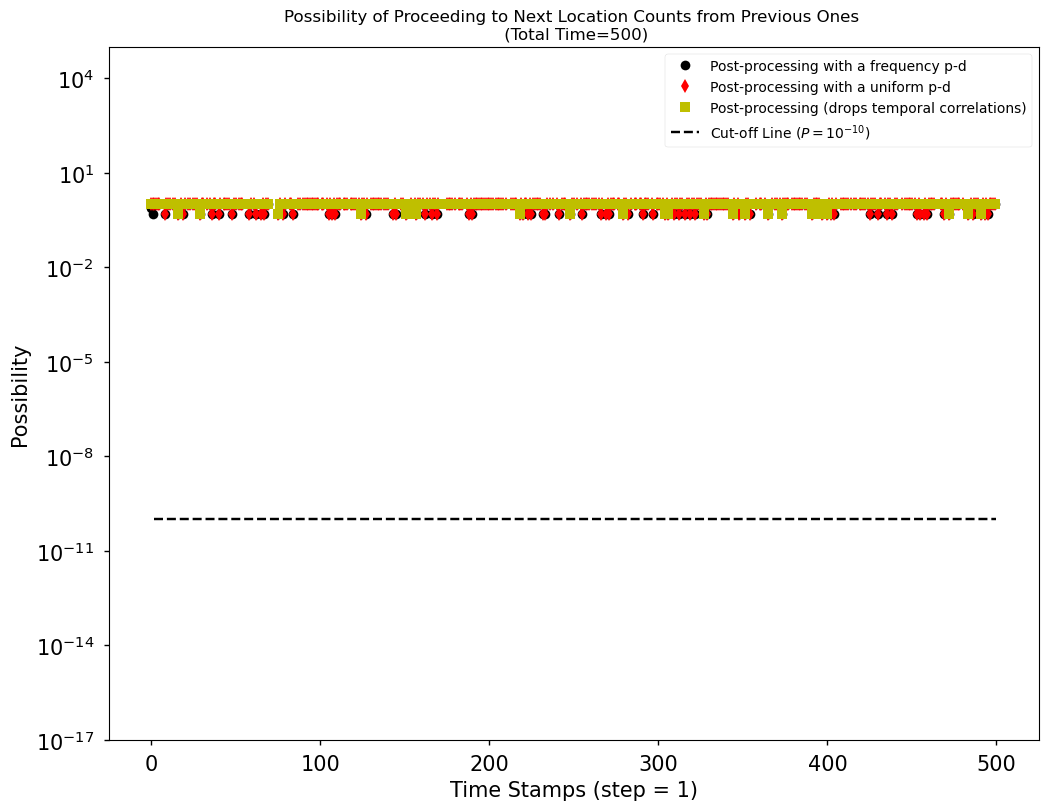

In [46]:
score[2]
plt.figure(figsize = (12,9))
plt.semilogy(score[0],'ko',label = r'Post-processing with a frequency p-d')
plt.semilogy(score[1],'rd',label = r'Post-processing with a uniform p-d')
plt.semilogy(score[2],'ys',label = r'Post-processing (drops temporal correlations)')
plt.semilogy([2,500],[1e-10,1e-10],'k--',label= r'Cut-off Line ($P=10^{-10}$)')
plt.xlabel('Time Stamps (step = 1)',fontsize = 15)
plt.ylabel('Possibility',fontsize = 15)
plt.ylim(1e-17,1e5)
plt.title('Possibility of Proceeding to Next Location Counts from Previous Ones \n (Total Time=500)')
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend()
#plt.savefig('fig(Possiblility of Proceeding to Next Location Counts)',dpi = 600)
plt.show()

C:\Users\joshu\AppData\Local\Temp\ipykernel_680\188617798.py:14: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0,1e8)


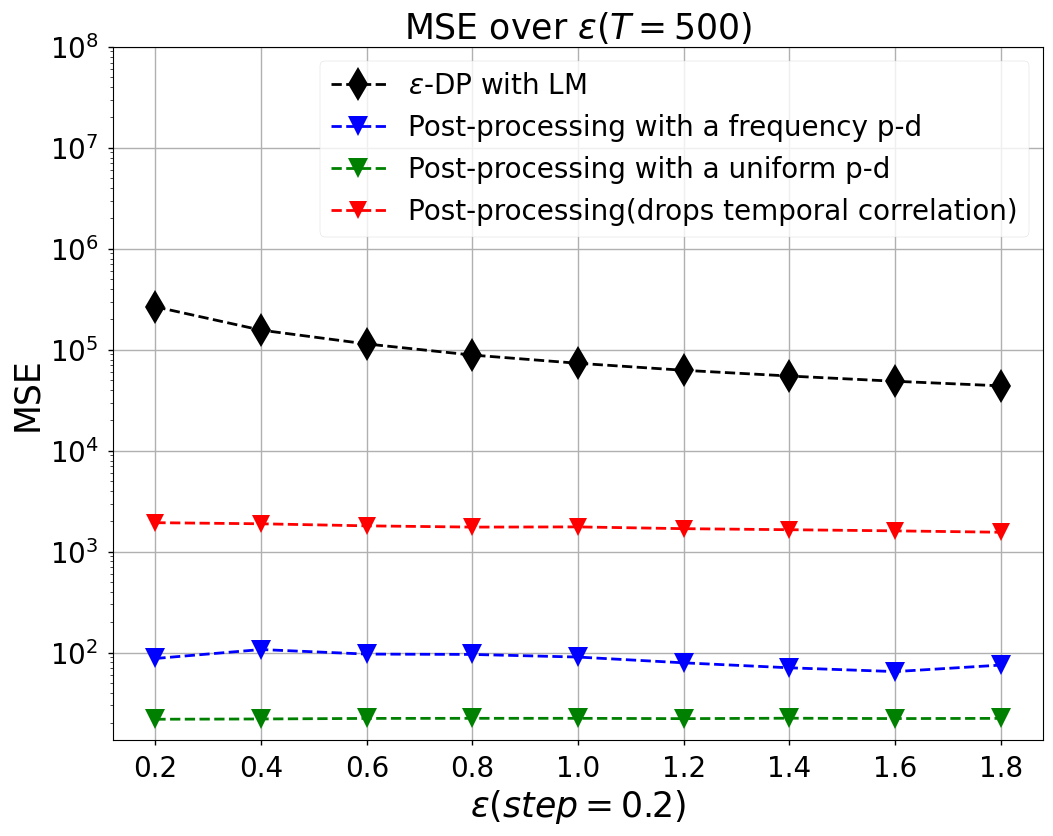

In [77]:
x_e = arange(0.2,2,step=0.2)
plt.figure(figsize = (12,9))
plt.semilogy(x_e,noisyMSE_e,linestyle = '--',marker = 'd',color = 'k',label = '$\epsilon$-DP with LM',linewidth = 2,markersize=17)
plt.semilogy(x_e,optimalMSE1_e,'bv--',label = 'Post-processing with a frequency p-d',linewidth = 2,markersize=15)
plt.semilogy(x_e[:],optimalMSE1_uniform_e[:],'gv--',label = 'Post-processing with a uniform p-d',linewidth = 2,markersize=15)
#plt.semilogy(x_e[6:],optimalMSE1_uniform_e[6:],'gv--',linewidth = 1,markersize=10)
plt.semilogy(x_e,optimalMSE2_e,'rv--',label = 'Post-processing(drops temporal correlation)',linewidth = 2,markersize=13)
#plt.semilogy(x_e,alpha_noisyMSE_e,linestyle = '--',marker = 'd',color = 'y',label = 'alpha-DP with LM',linewidth = 1,markersize=10)
plt.xlabel('$\epsilon (step = 0.2)$',fontsize=25)
plt.ylabel('MSE',fontsize=25)
plt.title(r'MSE over $\epsilon$($T=500$)',fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylim(0,1e8)
plt.legend(fontsize=20)
plt.grid()
#plt.savefig(r'fig(MSEoverEpsilon,time=500,n=200,s=0)GRB1.png',dpi = 600)
plt.show()

C:\Users\joshu\AppData\Local\Temp\ipykernel_680\3497995395.py:11: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0,1e12)


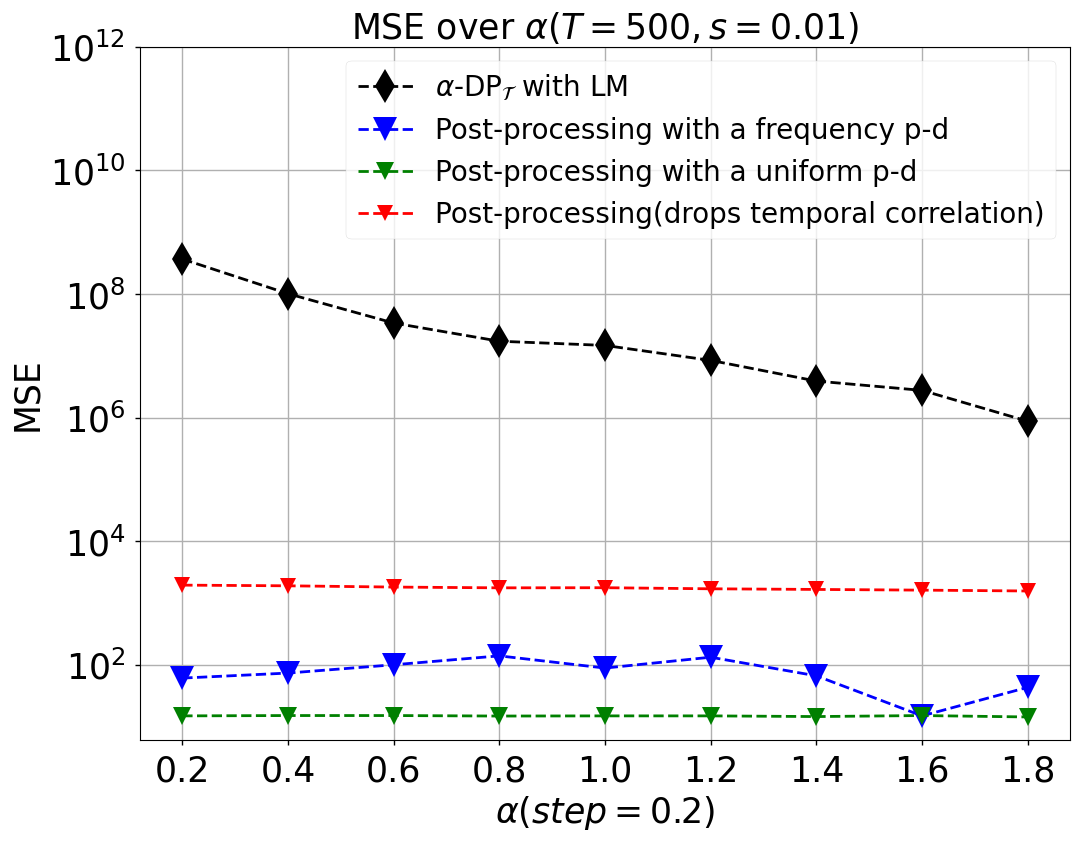

In [53]:
x_a = arange(0.2,2,step=0.2)
plt.figure(figsize = (12,9))
plt.semilogy(x_a,noisyMSE_a,linestyle = '--',marker = 'd',color = 'k',label = r'$\alpha $-DP$_\mathcal{T}$ with LM',linewidth = 2,markersize=17)
plt.semilogy(x_a,optimalMSE1_a,'bv--',label = 'Post-processing with a frequency p-d',linewidth = 2,markersize=17)
plt.semilogy(x_a[:],optimalMSE1_uniform_a[:],'gv--',label = 'Post-processing with a uniform p-d',linewidth = 2,markersize=13)
#plt.semilogy(x_e[6:],optimalMSE1_uniform_e[6:],'gv--',linewidth = 1,markersize=10)
plt.semilogy(x_e,optimalMSE2_e,'rv--',label = 'Post-processing(drops temporal correlation)',linewidth = 2,markersize=12)
#plt.semilogy(x_e,alpha_noisyMSE_e,linestyle = '--',marker = 'd',color = 'y',label = 'alpha-DP with LM',linewidth = 1,markersize=10)
plt.xlabel(r'$\alpha (step = 0.2)$',fontsize=25)
plt.ylabel('MSE',fontsize=25)
plt.ylim(0,1e12)
plt.title(r'MSE over $\alpha$($T=500,s=0.01$)',fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=20)
plt.grid()
#plt.savefig(r'fig(MSEoverAlpha,time=500,n=200,s=0.01)GRB1.png',dpi = 600)
plt.show()

C:\Users\joshu\AppData\Local\Temp\ipykernel_680\3325878953.py:12: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0,1e11)


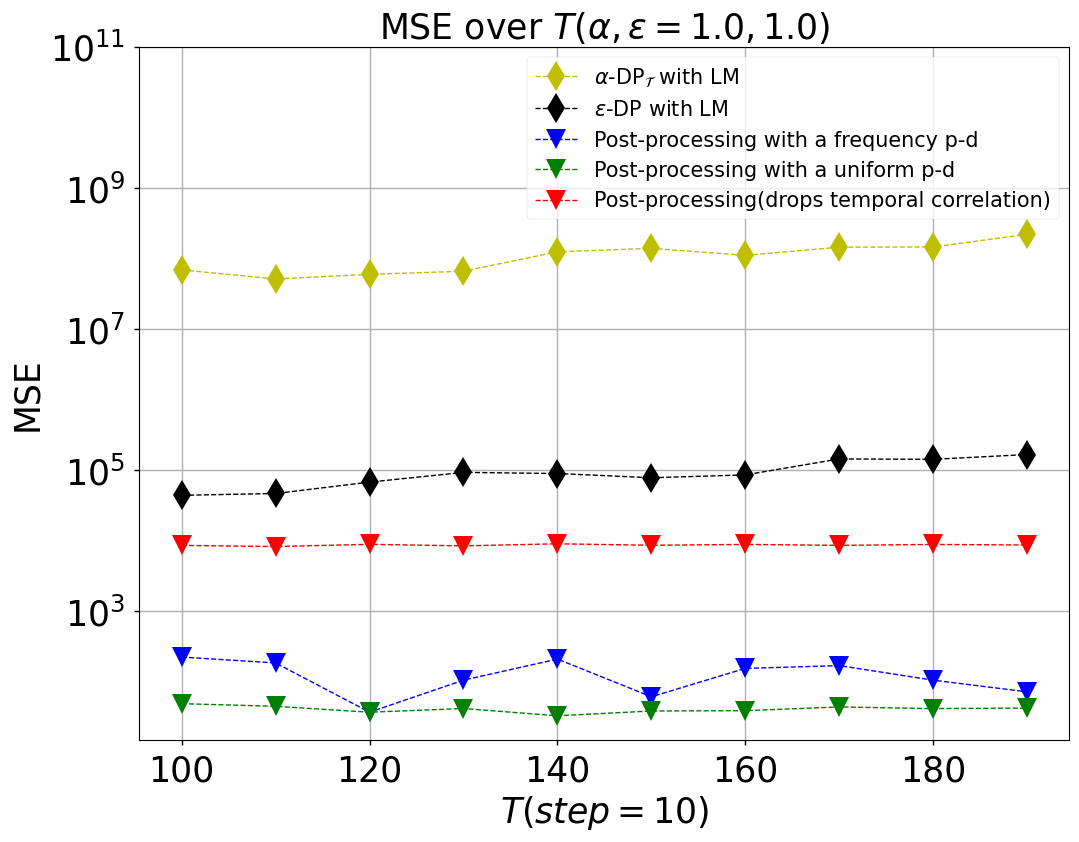

In [73]:
x_t = arange(100,200,step=10)
plt.figure(figsize = (12,9))
plt.semilogy(x_t,alpha_noisyMSE_t,linestyle = '--',marker = 'd',color = 'y',label = r'$\alpha$-DP$_\mathcal{T}$ with LM',linewidth = 1,markersize=15)
plt.semilogy(x_t,noisyMSE_t,linestyle = '--',marker = 'd',color = 'k',label = '$\epsilon$-DP with LM',linewidth = 1,markersize=15)
plt.semilogy(x_t,optimalMSE1_t,'bv--',label = 'Post-processing with a frequency p-d',linewidth = 1,markersize=15)
plt.semilogy(x_t,optimalMSE1_uniform_t,'gv--',label = 'Post-processing with a uniform p-d',linewidth = 1,markersize=15)
#plt.semilogy(x[:],optimalMSE1_uniform[6:],'gv--',linewidth = 1,markersize=10)
plt.semilogy(x_t,optimalMSE2_t,'rv--',label = 'Post-processing(drops temporal correlation)',linewidth = 1,markersize=15)
plt.xlabel('$T (step = 10)$',fontsize=25)
plt.ylabel('MSE',fontsize=25)
plt.title(r'MSE over $T$($\alpha, \epsilon=1.0, 1.0$)',fontsize=25)
plt.ylim(0,1e11)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=15)
plt.grid()
#plt.savefig(r'fig(MSEoverT)(1.0,n_loc=3,n_user=200,s=0.01)GRB1.png',dpi = 600)
plt.show()


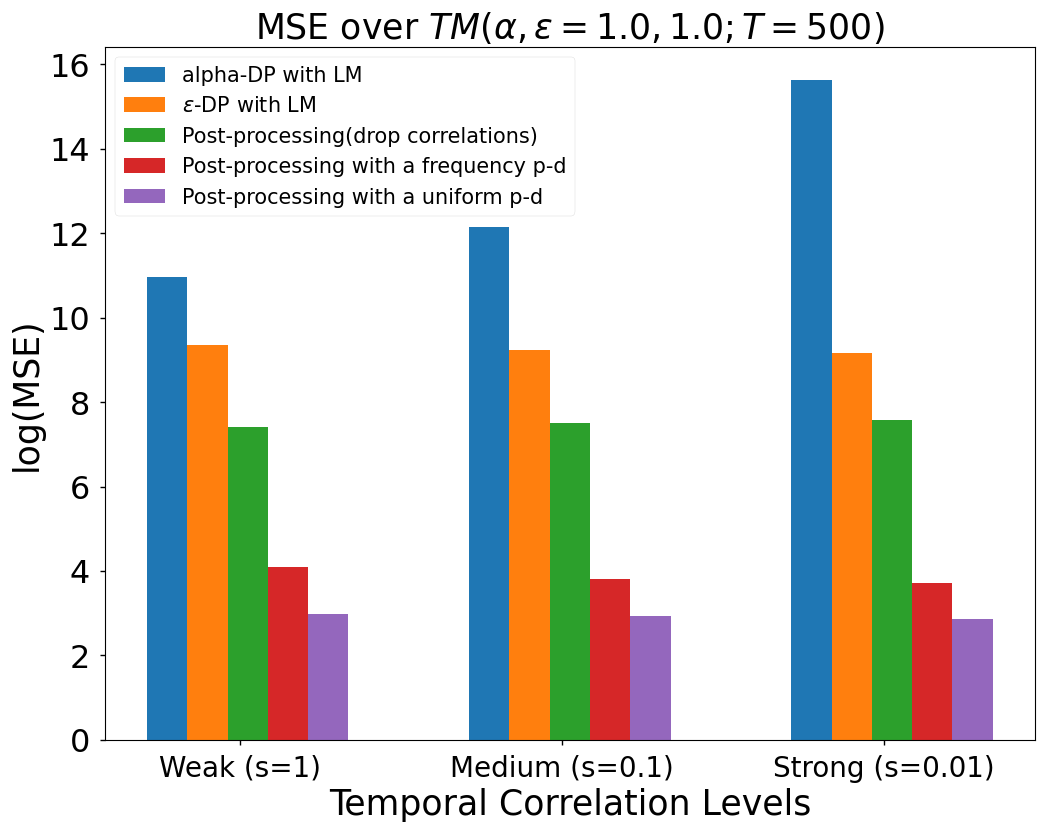

In [68]:
x = arange(3)
x_labels = ['Weak (s=1)','Medium (s=0.1)','Strong (s=0.01)']
total_width, n = 0.5, 4
width = total_width/n
x1 = x-9*width/5
x2 = x1+width
x3 = x2+width
x4 = x3+width
x5 = x4+width
plt.figure(figsize = (12,9))
plt.bar(x1,log(alpha_noisyMSE),width=width,label = 'alpha-DP with LM')
plt.bar(x2,log(noisyMSE),width=width,label = '$\epsilon$-DP with LM')
plt.bar(x3,log(optimalMSE2),width=width,label = 'Post-processing(drop correlations)')
plt.bar(x4,log(optimalMSE1),width=width,label = 'Post-processing with a frequency p-d')
plt.bar(x5,log(optimalMSE1_uniform),width=width,label = 'Post-processing with a uniform p-d')
plt.xticks(x,x_labels,rotation=0,fontsize=20)
plt.yticks(fontsize=23)
#plt.ylim(0,25.0)
plt.ylabel('log(MSE)',fontsize=25)
plt.xlabel('Temporal Correlation Levels',fontsize=25)
plt.title(r'MSE over $TM$($\alpha, \epsilon=1.0,1.0; T=500$)',fontsize=25)
plt.legend(fontsize=15)
#plt.savefig(r'fig(MSEoverTM)(1.0,T=500)GRB1.png',dpi = 600)
plt.show()


In [110]:
TM_i = array([[0.2,0.3,0.5],[0.1,0.0,0.9],[0.5,0.2,0.3]])
T = 100
epsilon_t = 1.0/T
qM,dM,aM = precomput_para(TM_i)
BPL = []
for i in range(T):
    if i == 0:
        alpha = epsilon_t
    else:
        alpha = calLeakPre(alpha,qM,dM,aM,epsilon_t)
    BPL.append(alpha)

C:\Users\joshu\AppData\Local\Temp\ipykernel_14372\1467430158.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  aArr.append(log(((q[l]-d[l])/(qArr[l]*d[l]-dArr[l]*q[l]))+1))
C:\Users\joshu\AppData\Local\Temp\ipykernel_14372\1467430158.py:39: RuntimeWarning: invalid value encountered in double_scalars
  aArr.append(log(((q[l]-d[l])/(qArr[l]*d[l]-dArr[l]*q[l]))+1))


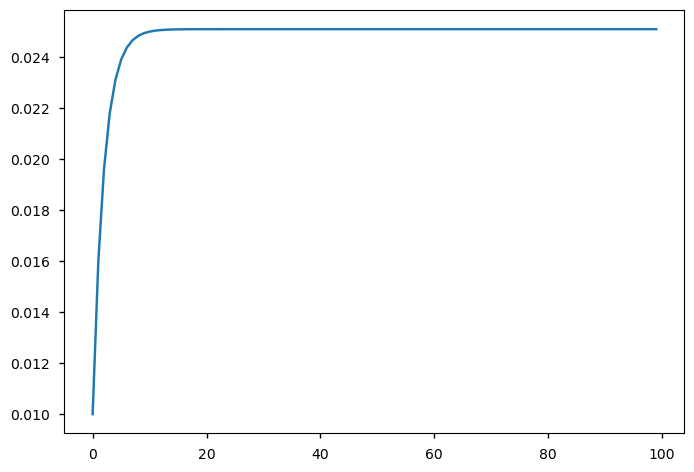

In [111]:
plt.plot(BPL)